In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings('ignore')


wage = pd.read_csv('wage.csv').dropna()
wage['hwage'] = wage["wage"]/wage["hours"]

In [83]:
wage

,wage,hours,lhwage,IQ,educ,exper,tenure,age,married,black,south,urban,sibs,brthord,meduc,feduc,hwage
0,769,40,2.956212,93,12,11,2,31,1,0,0,1,1,2.0,8.0,8.0,19.225000
2,825,40,3.026504,108,14,11,9,33,1,0,0,1,1,2.0,14.0,14.0,20.625000
3,650,40,2.788093,96,12,13,7,32,1,0,0,1,4,3.0,12.0,12.0,16.250000
4,562,40,2.642622,74,11,14,5,34,1,0,0,1,10,6.0,6.0,11.0,14.050000
6,600,40,2.708050,91,10,13,0,30,0,0,0,1,1,2.0,8.0,8.0,15.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
924,1442,40,3.584907,113,16,8,10,35,1,0,1,1,2,2.0,8.0,8.0,36.050000
925,645,45,2.662588,93,12,11,3,35,1,0,1,0,7,7.0,7.0,8.0,14.333333
928,477,45,2.360854,100,12,9,3,31,1,0,1,0,3,3.0,7.0,7.0,10.600000
929,664,60,2.403938,82,16,10,9,34,1,1,1,1,3,4.0,16.0,16.0,11.066667


Efecto de la educación en el salario (logaritmo)

In [84]:
model = smf.ols('np.log(hwage) ~ educ', data=wage).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2.3071,0.104,22.089,0.000,2.102,2.512
educ,0.0536,0.008,7.114,0.000,0.039,0.068


In [85]:
model = smf.ols('hwage ~ educ', data=wage).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,6.4811,2.349,2.759,0.006,1.869,11.093
educ,1.2069,0.169,7.123,0.000,0.874,1.540


In [86]:
wage.wage.mean()

988.4751131221719

Utiliza los demás controles

In [87]:
controls = ['IQ', 'exper', 'tenure', 'age', 'married', 'black',
            'south', 'urban', 'sibs', 'brthord', 'meduc', 'feduc']

In [88]:
'+'.join(controls)

'IQ+exper+tenure+age+married+black+south+urban+sibs+brthord+meduc+feduc'

In [89]:
model = smf.ols('np.log(hwage) ~ educ +' + '+'.join(controls), data=wage).fit()

model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1.1156,0.232,4.802,0.000,0.659,1.572
educ,0.0411,0.010,4.075,0.000,0.021,0.061
IQ,0.0038,0.001,2.794,0.005,0.001,0.006
exper,0.0153,0.005,3.032,0.003,0.005,0.025
tenure,0.0094,0.003,2.836,0.005,0.003,0.016
age,0.0086,0.006,1.364,0.173,-0.004,0.021
married,0.1795,0.053,3.415,0.001,0.076,0.283
black,-0.0801,0.063,-1.263,0.207,-0.205,0.044
south,-0.0397,0.035,-1.129,0.259,-0.109,0.029
urban,0.1926,0.036,5.418,0.000,0.123,0.262




# Teorema de Frisch-Waugh-Lovell

El **Teorema de Frisch-Waugh-Lovell** establece que en una regresión múltiple:

$$
Y = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \dots + \beta_k X_k + \epsilon
$$

el coeficiente $(\beta_1$) puede obtenerse de manera equivalente en tres pasos:

##  Paso 1: Regresión de $Y$ contra $(X_2, ..., X_k)$
Regresamos $Y$ contra $(X_2, X_3, ..., X_k)$ y obtenemos los residuos $R_Y$:

$$
Y = \gamma_0 + \gamma_2 X_2 + \dots + \gamma_k X_k + R_Y
$$

Donde $R_Y$ representa la parte de $Y$ que *no* está explicada por $X_2, ..., X_k$.

## Paso 2: Regresión de $X_1$ contra $(X_2, ..., X_k)$
Regresamos $X_1$ contra $(X_2, X_3, ..., X_k)$ y obtenemos los residuos $R_{X_1}$:

$$
X_1 = \delta_0 + \delta_2 X_2 + \dots + \delta_k X_k + R_{X_1}
$$

Donde $R_{X_1}$ representa la parte de $X_1$ que no está explicada por $(X_2, ..., X_k)$.

## Paso 3: Regresión de $R_Y$ contra $R_{X_1}$

Finalmente, regresamos $R_Y$ contra $R_{X_1}$:

$$
R_Y = \beta_1 R_{X_1} + \nu
$$

El coeficiente $\beta_1$ obtenido en esta regresión es **idéntico** al de la regresión original:

$$
Y = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \dots + \beta_k X_k + \epsilon
$$

## Conclusión  
El teorema demuestra que el **efecto de $X_1$ sobre $Y$ ** se puede calcular sin necesidad de incluir todas las variables en una misma regresión, utilizando residuos de regresiones auxiliares.



### Implementando el teorema 

### Parte 1

Predice el salario a partir de todos los controles excepto por la educación

In [90]:
m1 = smf.ols('np.log(hwage) ~' + '+'.join(controls), data=wage).fit()

Obten los residuales, que es la parte del salario que no esta explicada por los controles

In [91]:
# Predecir el salario sin la educacion
residuales_m1 = m1.resid

### Parte 2

Predice la educación a partir de los demás controles 

In [92]:
m2 = smf.ols('educ ~' + '+'.join(controls), data=wage).fit()

Obten los residuales, que es la información que está en educación que no puede ser explicada por los controles

In [93]:
residuales_m2 = m2.resid

### Parte 3

Crea un modelo que prediga los residuales del modelo 1 a partir de los residuales del modelo 2

In [94]:
modelo = smf.ols("resid1 ~resid2", data=wage.assign(resid1=residuales_m1, resid2=residuales_m2)).fit()

modelo.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1.883e-14,0.015,1.22e-12,1.000,-0.030,0.030
resid2,0.0411,0.010,4.112,0.000,0.021,0.061


Esto tiene que ser *exactamente igual* que predecir con todos 


¿Por qué esto es importante?

*quiere decir que cuando hacemos una regresión, el coeficiente $\beta_1$ es el efecto de $x_1$ tomando en cuenta toda la información contenida en los demás coeficientes*

¿Por qué esto es importante?

Quiere decir que si hacemos una regresión y usamos todos los controles, podemos aislar el efecto particular de cualquier tratamiento, siempre y cuando se usen los controles pertinentes. 


### Ejemplo de data en el mundo real

Tenemos las ventas de una tienda de helados.

El vendedor de helados quiere cobrar siempre lo más que pueda pero hay una intuición obvia. 

*Si cobro muy caro, nadie va venir*

Contrata a un Data Scientist para que le ayude a entender cuanto cobrar.

Primer paso, regresión lineal

In [95]:
df = pd.read_csv('ice_cream_sales.csv')

In [96]:
df.head()

,temp,weekday,cost,price,sales
0,17.3,6,1.5,5.6,173
1,25.4,3,0.3,4.9,196
2,23.3,5,1.5,7.6,207
3,26.9,1,0.3,5.3,241
4,20.2,1,1.0,7.2,227


Esto suena absurdo, ¿como es posible que a mayor precio, más ventas?

Bivariado de las ventas

pd.qcut(df_calibracion['predicciones'], q=5, labels=False, duplicates='drop')

In [97]:
df.corr()

,temp,weekday,cost,price,sales
temp,1.000000,-0.006214,0.000027,-0.003644,0.375951
weekday,-0.006214,1.000000,0.009161,0.004559,0.011888
cost,0.000027,0.009161,1.000000,0.390435,-0.015494
price,-0.003644,0.004559,0.390435,1.000000,0.075544
sales,0.375951,0.011888,-0.015494,0.075544,1.000000


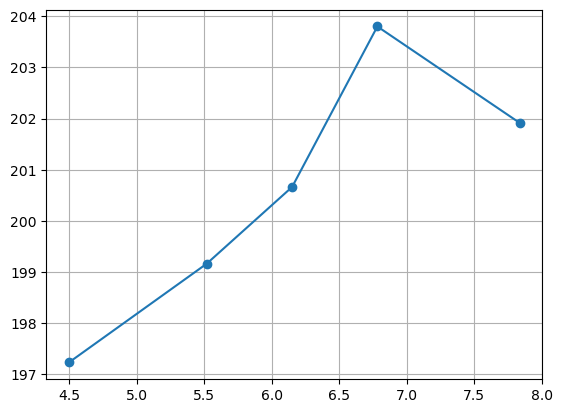

In [98]:
df['bin_price'] =pd.qcut(df['price'], q=5, labels=False, duplicates='drop')

grouped = df.groupby('bin_price').mean()

plt.plot(grouped.price, grouped.sales, marker="o")
plt.grid()

In [99]:
model = smf.ols('sales ~ price', data=df).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,192.9679,1.013,190.414,0.000,190.981,194.954
price,1.2294,0.162,7.575,0.000,0.911,1.547


In [100]:
df.head()

,temp,weekday,cost,price,sales,bin_price
0,17.3,6,1.5,5.6,173,1
1,25.4,3,0.3,4.9,196,0
2,23.3,5,1.5,7.6,207,4
3,26.9,1,0.3,5.3,241,1
4,20.2,1,1.0,7.2,227,4


Efectiamente, según los datos a mayor precio, mayor venta.


Pasa que los vendedores no son tontos, algunos días donde es feriado o que hace mucho calor suben el precio ... y es justamente donde se vende más.

Podemos usar una regrsion linal _controlando por esos factores_.


In [101]:
model = smf.ols('sales ~ price  + C(weekday) + temp + cost', data=df).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,201.9694,1.004,201.146,0.000,200.001,203.938
C(weekday)[T.2],-33.8632,0.421,-80.432,0.000,-34.688,-33.038
C(weekday)[T.3],-33.5465,0.429,-78.287,0.000,-34.386,-32.707
C(weekday)[T.4],-33.5294,0.427,-78.441,0.000,-34.367,-32.692
C(weekday)[T.5],-33.4590,0.424,-78.856,0.000,-34.291,-32.627
C(weekday)[T.6],-33.4199,0.430,-77.660,0.000,-34.263,-32.576
C(weekday)[T.7],0.3086,0.408,0.757,0.449,-0.491,1.108
price,-4.0004,0.110,-36.413,0.000,-4.216,-3.785
temp,1.8331,0.028,65.779,0.000,1.778,1.888
cost,3.2659,0.264,12.366,0.000,2.748,3.784


Aqui ya podemos ver que el precio tiene un coeficiente negativo, dejando todo lo demás igual si sube el precio las ventas caen 

### Aplicando el teorema de Teorema de Frisch-Waugh-Lovell

In [102]:
m1 = smf.ols('sales ~ C(weekday) + temp + cost', data=df).fit()
m2 = smf.ols('price ~ C(weekday) + temp + cost', data=df).fit()
m3 = smf.ols('sales_resid ~ price_resid', data=df.assign(sales_resid=m1.resid, price_resid=m2.resid)).fit()

m3.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-4.843e-13,0.111,-4.38e-12,1.000,-0.217,0.217
price_resid,-4.0004,0.110,-36.428,0.000,-4.216,-3.785


### Caso 2

¿Qué tan buena es una medicina?

In [103]:
hospital = pd.read_csv('hospital_treatment.csv')

In [104]:
hospital.head()

,hospital,treatment,severity,days
0,1,1,29.686618,82
1,1,1,20.050340,57
2,1,1,20.302399,49
3,0,0,10.603118,44
4,0,0,8.332793,15


Regresion días y treatment

In [105]:
model = smf.ols('days~treatment', data = hospital).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,33.2667,2.662,12.498,0.000,27.968,38.566
treatment,14.1533,3.367,4.204,0.000,7.451,20.856


De entrada, parece que la medicina hace que los pacientes duren _más días en el hospital_


Pero ...

En realidad esta medicina se le da a los pacientes que están muy muy mal, aquí hay un sesgo en los datos.

Afortunadamente podemos controlar por severidad

In [106]:
model = smf.ols('days~treatment + severity', data = hospital).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,11.6641,2.000,5.832,0.000,7.681,15.647
treatment,-7.5912,2.269,-3.345,0.001,-12.110,-3.073
severity,2.2741,0.154,14.793,0.000,1.968,2.580


Ahora la medicina parece que si tiene buen efecto 

Pasa que también depende mucho de los hopspitales, hay hospitales que tienen más pacientes con severidad

In [107]:
# Group by hospital
hospital.groupby('hospital').mean()

,treatment,severity,days
hospital,,,
0,0.068966,7.944987,29.620690
1,0.941176,19.757954,49.215686


Pues hago un modelo que tenga todo, de una vez ... no puede ser malo-

In [108]:
model = smf.ols('days~treatment + severity + hospital', data = hospital).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,11.0111,2.118,5.198,0.000,6.792,15.230
treatment,-5.0945,3.492,-1.459,0.149,-12.049,1.861
severity,2.3865,0.195,12.251,0.000,1.999,2.774
hospital,-4.1535,4.413,-0.941,0.350,-12.943,4.636


El tratamiento tiene un p-value no significativo, ¿qué está pasando?


Recordar la formula del error estadard en una regresión:


$$\sigma^2 = \frac{\Sigma (y_i - \hat{y})^2}{n}$$

$$SE(\beta) = \sqrt{\frac{\sigma^2}{\Sigma (x - E[X])^2}} $$

Si la varianza de X es muy baja, el error estandard será *mayor*


¿Cómo es que la varianza de el tratamiento puede bajar en este caso?

A la hora de aplicar el Teorema de Frisch-Waugh-Lovel el hospital puede predecir la severidad, los residuales serán más pequeños y le predicción del efecto se ve afectada.


In [109]:
m1 = smf.ols('days~severity + hospital', data = hospital).fit()
m2 = smf.ols('treatment~severity + hospital', data = hospital).fit()
m3 = smf.ols('days_resid~treatment_resid', data = hospital.assign(days_resid=m1.resid, treatment_resid=m2.resid)).fit()

m3.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2.702e-14,0.827,3.27e-14,1.000,-1.646,1.646
treatment_resid,-5.0945,3.447,-1.478,0.143,-11.957,1.768


Si hacemos lo mismo, pero sin hospital el p-value ya es significativo

*Si el objetivo de su regresión está fuertemente ligado a interpretar los coeficientes, no agregar controles que predigan el tratamiento pero no tenga relación real con $y$*

### Un poco más sobre modelado 

Tenemos los datos de tarjeta de crédito de una empresa, queremos predecir cuanto va a gastar un usuario y en función de eso darle un límite de crédito.

Podemos asumir que :

1- A mayor ingreso, mayor gasto

2- A mayor límite de crédito, mayor gasto pero no en la misma proporción


In [110]:
spend = pd.read_csv('spend_data.csv')
spend


,wage,educ,exper,married,credit_score1,credit_score2,credit_limit,spend
0,950.0,11,16,1,500.0,518.0,3200.0,3848
1,780.0,11,7,1,414.0,429.0,1700.0,3144
2,1230.0,14,9,1,586.0,571.0,4200.0,4486
3,1040.0,15,8,1,379.0,411.0,1500.0,3327
4,1000.0,16,1,1,379.0,518.0,1800.0,3508
...,...,...,...,...,...,...,...,...
49995,840.0,12,13,1,466.0,482.0,2400.0,3441
49996,700.0,15,16,1,328.0,393.0,1100.0,2626
49997,930.0,14,16,1,552.0,339.0,1700.0,3066
49998,1550.0,17,7,1,569.0,536.0,3300.0,4568


In [111]:
spend['wage_bins'] = pd.qcut(spend['wage'], q=5, labels=False) + 1

Grafica el límite de crédito vs gasto, segmentado por salario 

Text(0.5, 1.0, 'Gasto vs Limite de credito, segmentado por salario')

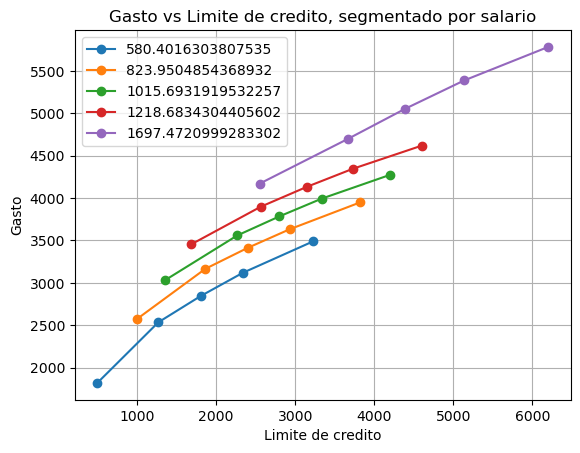

In [112]:
for i in np.sort(spend.wage_bins.unique()):
    flag_df=spend.query("wage_bins==@i")
    flag_df['credit_limit_bin'] = pd.qcut(flag_df['credit_limit'], q=5, labels=False) + 1
    grouped = flag_df.groupby('credit_limit_bin').mean()
    plt.plot(grouped.credit_limit, grouped.spend, label=np.mean(flag_df.wage), marker = 'o')

plt.legend()
plt.grid()
plt.xlabel("Limite de credito")
plt.ylabel("Gasto")
plt.title("Gasto vs Limite de credito, segmentado por salario")

Efectivamente, líite de crédito, mayor gasto pero no es lineal al segmentar por ingreso.

Predice el gasto usando una regresión simple de salrio y límite de crédito

In [113]:
model = smf.ols('spend ~ wage + credit_limit', data=spend).fit()
predicciones = model.predict(spend)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  spend   R-squared:                       0.949
Model:                            OLS   Adj. R-squared:                  0.949
Method:                 Least Squares   F-statistic:                 4.608e+05
Date:                Thu, 13 Feb 2025   Prob (F-statistic):               0.00
Time:                        20:36:14   Log-Likelihood:            -3.3935e+05
No. Observations:               50000   AIC:                         6.787e+05
Df Residuals:                   49997   BIC:                         6.787e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     1457.4571      2.694    541.036      0.000    1452.177    1462.737
wage             0.9980      0.003    323.873      0.000       0.992       1.004
credit_limit     0.4348      0.001    469.691      0.000       0.433       0.437
==============================================================================
Omnibus:                    11008.217   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            23698.062
Skew:                          -1.282   Prob(JB):                         0.00
Kurtosis:                       5.191   Cond. No.                     9.39e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.39e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [114]:
model = smf.ols('spend ~ wage + np.sqrt(credit_limit)', data=spend).fit()
predicciones2 = model.predict(spend)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  spend   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                 8.771e+05
Date:                Thu, 13 Feb 2025   Prob (F-statistic):               0.00
Time:                        20:36:14   Log-Likelihood:            -3.2388e+05
No. Observations:               50000   AIC:                         6.478e+05
Df Residuals:                   49997   BIC:                         6.478e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept               383.5002      2.746    139.662      0.000     378.118     388.882
wage                      1.0459      0.002    481.875      0.000       1.042       1.050
np.sqrt(credit_limit)    43.8504      0.065    672.633      0.000      43.723      43.978
==============================================================================
Omnibus:                     7910.493   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            13295.911
Skew:                          -1.056   Prob(JB):                         0.00
Kurtosis:                       4.385   Cond. No.                     4.45e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.45e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Utilizando una función no lineal vamos a linearizar el modelo

In [115]:
spend['predicciones1'] = predicciones
spend['predicciones2'] = predicciones2

Text(0.5, 1.0, 'Gasto vs Limite de credito, segmentado por salario')

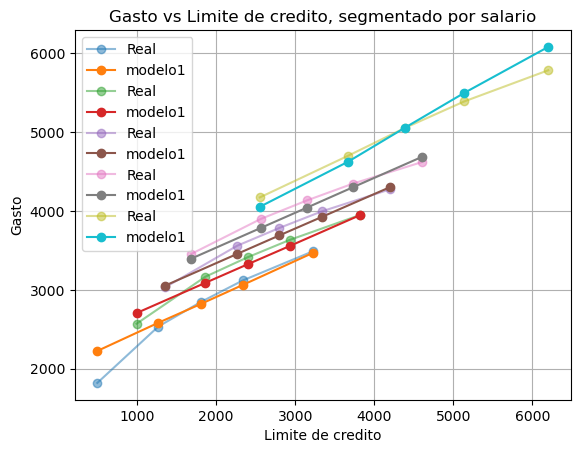

In [117]:
for i in np.sort(spend.wage_bins.unique()):
    flag_df=spend.query("wage_bins==@i")
    flag_df['credit_limit_bin'] = pd.qcut(flag_df['credit_limit'], q=5, labels=False) + 1
    grouped = flag_df.groupby('credit_limit_bin').mean()
    plt.plot(grouped.credit_limit, grouped.spend, label="Real", marker = 'o', alpha=0.5)
    plt.plot(grouped.credit_limit, grouped.predicciones1, label="modelo1", marker = 'o')
    

plt.legend()
plt.grid()
plt.xlabel("Limite de credito")
plt.ylabel("Gasto")
plt.title("Gasto vs Limite de credito, segmentado por salario")

Text(0.5, 1.0, 'Gasto vs Limite de credito, segmentado por salario')

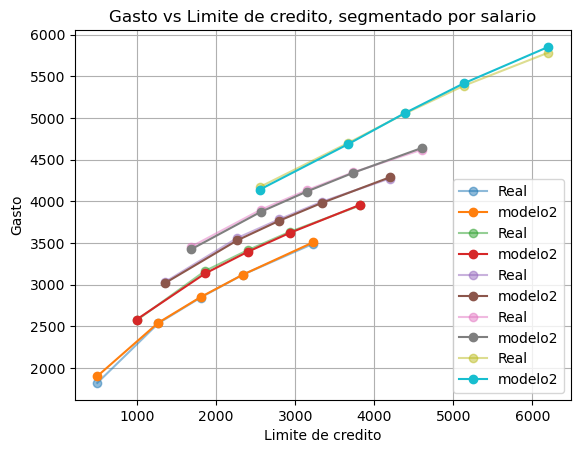

In [118]:
for i in np.sort(spend.wage_bins.unique()):
    flag_df=spend.query("wage_bins==@i")
    flag_df['credit_limit_bin'] = pd.qcut(flag_df['credit_limit'], q=5, labels=False) + 1
    grouped = flag_df.groupby('credit_limit_bin').mean()
    plt.plot(grouped.credit_limit, grouped.spend, label="Real", marker = 'o', alpha=0.5)
    plt.plot(grouped.credit_limit, grouped.predicciones2, label="modelo2", marker = 'o')
    

plt.legend()
plt.grid()
plt.xlabel("Limite de credito")
plt.ylabel("Gasto")
plt.title("Gasto vs Limite de credito, segmentado por salario")

¿Por qué esto mejora?

Bivarido segmentado por el límite de crédito con predicciones 1

Ahora con la segunda prediccion

La predicción 2 se parece más a la realidad